# Austin Animal Shelter Data Cleaning 

In [1]:
# Import packages
%matplotlib inline
import requests
import pandas as pd
import numpy as np
from urllib.error import HTTPError
import matplotlib.pyplot as plt

In [2]:
# Grab the Austin Animal Shelter Data
# Files can be read in 1000 at a time 
endpoint = 'https://data.austintexas.gov/resource/9t4d-g238.json'
count = 1000
pages = 100

In [3]:
# Loops through 78K worth of data 
# until we receive a 404 error
# which is the end of the data
results = []
params = {'$limit': count, '$offset': 0}

for i in range(0, pages):
    
    try:
        r = requests.get(endpoint, params=params)
        results.append(r.json())
        params['$offset'] = count
        count += 1000
        
    except HTTPError as err:
        if err.response.status_code == '404':
            break
        else:
            print(err.response.status_code)

len(results)

100

In [4]:
# We convert the list of JSON results into
# a pandas dataframe by using json_normalize()
# the results are appended to an empty dataframe
outcome_df = pd.DataFrame()

for i in results:
    outcome_df = outcome_df.append(pd.io.json.json_normalize(i))

len(outcome_df)

100000

In [5]:
# Filters out just the cat data
cats_df = outcome_df[outcome_df['animal_type'] == 'Cat'].reset_index()
del cats_df['index']
print(len(cats_df))
cats_df.head()

38471


,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,7 years,A808975,Cat,Domestic Shorthair,Gray Tabby,2012-05-19T00:00:00.000,2019-11-21T15:07:00.000,2019-11-21T15:07:00.000,NaN,Snr,Transfer,Intact Female
1,2 years,A808990,Cat,Russian Blue Mix,Blue,2017-11-17T00:00:00.000,2019-11-21T15:07:00.000,2019-11-21T15:07:00.000,NaN,Snr,Transfer,Unknown
2,3 months,A809000,Cat,Siamese Mix,Seal Point,2019-08-02T00:00:00.000,2019-11-21T15:06:00.000,2019-11-21T15:06:00.000,NaN,Snr,Transfer,Intact Male
3,2 years,A808996,Cat,Domestic Medium Hair,Brown Tabby/White,2017-11-17T00:00:00.000,2019-11-21T15:06:00.000,2019-11-21T15:06:00.000,NaN,Snr,Transfer,Intact Female
4,7 years,A808674,Cat,Domestic Shorthair,Gray,2012-11-21T00:00:00.000,2019-11-21T15:05:00.000,2019-11-21T15:05:00.000,Kitty Kitty,NaN,Return to Owner,Intact Male


In [7]:
# Extract data into a csv
outcome_df.to_csv('C:/Users/mckee/Documents/College/$Graduate School/ADTA 5130/Austin Animal Shelter Project/Data/aac_outcomes_working.csv', index=False, encoding='utf-8')
cats_df.to_csv('C:/Users/mckee/Documents/College/$Graduate School/ADTA 5130/Austin Animal Shelter Project/Data/cats_working.csv', index=False, encoding='utf-8')

In [8]:
# Each row represents one outcome
# Use count to denote the number of observations
cats_df['count'] = 1

In [9]:
# sex_upon_outcome combines gender and neutered/spayed
# Create two new variables to split up the gender/neutered combination
cats_df['sex'] = np.where(cats_df['sex_upon_outcome'].str.contains('Male'), 'Male', 'Female')
cats_df['Spay/Neuter'] = np.where(cats_df['sex_upon_outcome'].str.contains('Intact'), 'No', 'Yes')

In [13]:
# age_upon_outcome combines the value and unit of age e.g. 1 week
# Create two variables to denote the age in a number format based on the unit
# The unique() function will find the year, month, week, and day intervals 
cats_df['age_upon_outcome'].head()
cats_df = cats_df[cats_df['age_upon_outcome'] != 'NULL']
cats_df['Periods'], cats_df['Period Range'] = cats_df['age_upon_outcome'].str.split(' ').str[0].fillna(0).astype(int), cats_df['age_upon_outcome'].str.split(' ').str[1].fillna(0)
cats_df['Period Range'].unique()

# This section will convert the unit intervals into days
cats_df['Period Range'] = np.where(cats_df['Period Range'].str.contains('day'), 1, 
                                   np.where(cats_df['Period Range'].str.contains('week'), 7, 
                                            np.where(cats_df['Period Range'].str.contains('month'), 30, 
                                                     np.where(cats_df['Period Range'].str.contains('year'), 365, 0)))).astype(int)

cats_df['outcome_age_(days)'] = cats_df['Period Range'] * cats_df['Periods']
cats_df['outcome_age_(years)'] = cats_df['outcome_age_(days)'] / 365

In [15]:
# Defines the difference between adult and baby
cats_df['Cat/Kitten (outcome)'] = np.where(cats_df['outcome_age_(days)'] >= 180, 'Cat', 'Kitten')
cats_df['sex_age_outcome'] = cats_df['sex_upon_outcome'] + ' ' + cats_df['Cat/Kitten (outcome)']
cats_df['age_group'] = pd.cut(cats_df['outcome_age_(years)'], 10)
cats_df['age_group'].value_counts()

(-0.022, 2.2]    33101
(2.2, 4.4]        1821
(4.4, 6.6]        1122
(6.6, 8.8]         900
(8.8, 11.0]        815
(11.0, 13.2]       404
(13.2, 15.4]       191
(15.4, 17.6]        68
(17.6, 19.8]        27
(19.8, 22.0]        16
Name: age_group, dtype: int64

In [17]:
# Convert dates to work in pandas
cats_df['date_of_birth'] = pd.to_datetime(cats_df['date_of_birth'])

cats_df['dob_year'] = cats_df['date_of_birth'].dt.year
cats_df['dob_month'] = cats_df['date_of_birth'].dt.month
cats_df['dob_monthyear'] = pd.to_datetime(cats_df['monthyear']).dt.to_period('M')

cats_df['datetime'] = pd.to_datetime(cats_df['datetime'])
cats_df['outcome_month'] = cats_df['datetime'].dt.month
cats_df['outcome_year'] = cats_df['datetime'].dt.year
cats_df['outcome_weekday'] = cats_df['datetime'].dt.weekday_name
cats_df['outcome_hour'] = cats_df['datetime'].dt.hour

In [21]:
# Count by breeds
cats_df['breed'].value_counts()
cats_df['breed'] = cats_df['breed'].str.lower().str.replace('mix', '').str.replace('medium hair', 'mediumhair').str.strip()

cfa_breeds = ['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'American Wirehair', 
              'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Burmilla', 
              'Chartreux', 'Colorpoint Shorthair', 'Cornish Rex', 'Devon Rex', 'Egyptian Mau', 'European Burmese', 
              'Exotic', 'Havana Brown', 'Japanese Bobtail', 'Korat', 'LaPerm', 'Maine Coon', 'Manx', 
              'Norwegian Forest Cat', 'Ocicat', 'Oriental', 'Persian', 'Ragamuffin', 'Ragdoll', 'Russian Blue', 
              'Scottish Fold', 'Selkirk Rex', 'Siamese', 'Siberian', 'Singapura', 'Somali', 'Tonkinese', 
              'Turkish Angora', 'Turkish Van']

cfa_breeds = [i.lower() for i in cfa_breeds]
cfa_breeds = '|'.join(cfa_breeds)

cats_df = pd.concat([cats_df, 
                     cats_df['breed'].str.split('/', expand=True).rename(columns={0:'breed1', 1:'breed2'})], 
                    axis=1)

cats_df['cfa_breed'] = np.where((cats_df['breed1'].str.contains(cfa_breeds)) | 
                                (cats_df['breed2'].str.contains(cfa_breeds)), 
                                True, False)

cats_df['domestic_breed'] = np.where((cats_df['breed1'].str.contains(cfa_breeds) == False) | 
                                     (cats_df['breed2'].str.contains(cfa_breeds) == False), 
                                     True, False)

In [26]:
# Count by color
cats_df['color'].value_counts()
coat_patterns = ['tabby', 'tortie', 'tortoiseshell', 'calico', 'smoke', 'torbie',
                 'colorpoint', 'point', 'brindle', 'agouti', 'bicolor', 'tricolor']

# Create the regex string by joining the coat patterns with | and encapsulating them in parantheses
coat_reg = '(' + '|'.join(coat_patterns) + ')'

cats_df['color'] = cats_df['color'].str.lower()

cats_df['coat_pattern'] = cats_df['color'].str.extract(coat_reg, expand=False)

cats_df['color'] = cats_df['color'].str.replace(coat_reg, '').str.strip()

cats_df = pd.concat([cats_df, 
                     cats_df['color'].str.split('/', expand=True).rename(columns={0:'color1', 1:'color2'})], axis=1)

cats_df['color1'] = np.where(cats_df['color1'] == '', 'Breed Specific', cats_df['color1'])

cats_df['coat'] = np.where(cats_df['color1'] == 'Breed Specific', cats_df['coat_pattern'], cats_df['color1'])

In [27]:
# Extract clean data to csv
cats_df.to_csv('C:/Users/mckee/Documents/College/$Graduate School/ADTA 5130/Austin Animal Shelter Project/Data/cats_df_clean.csv', index=False, encoding='utf-8')

In [28]:
# References
# http://sheltermedicine.vetmed.ufl.edu/files/2011/11/identification-and-coat-colors-patterns.pdf
# http://cfa.org/Breeds.aspx

# Austin Animal Shelter Exploratory Data Analysis

In [29]:
# Import packages
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

In [30]:
# Read from clean data csv
cats_df = pd.read_csv('C:/Users/mckee/Documents/College/$Graduate School/ADTA 5130/Austin Animal Shelter Project/Data/cats_df_clean.csv')

In [50]:
# Visualize 
sns.set(font_scale=1.7, palette=sns.color_palette("Set1", n_colors=15, desat=.5), color_codes=False)
# sns.xkcd_palette(sns.xkcd_rgb)
sns.set_style('ticks')

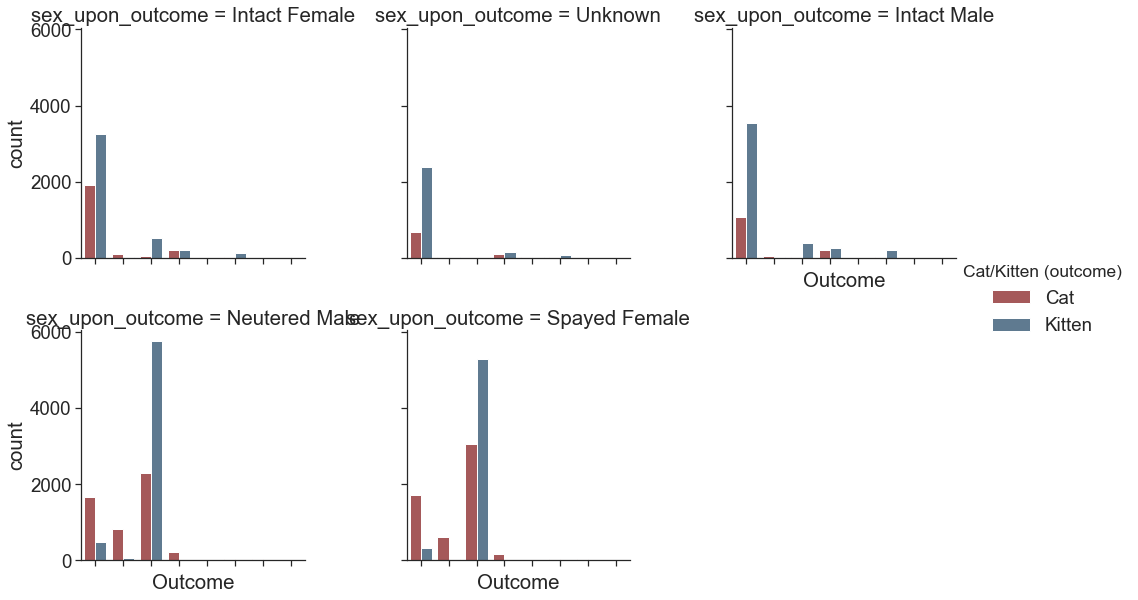

In [51]:
# Visualize spayed/neutered gender and intact gender 
g = sns.factorplot(x='outcome_type', hue='Cat/Kitten (outcome)', col='sex_upon_outcome', 
               col_wrap=3, data=cats_df, kind='count', size=4.5)

g.set_xticklabels(rotation=90)
g.set_xlabels('Outcome')

In [61]:
# Bug in rbga argument
# doesn't display cats by age and neutered/spayed
transfer_subtype_counts = cats_df[cats_df['outcome_type'] == 'Transfer']
transfer_subtype_counts = transfer_subtype_counts.groupby(['sex_upon_outcome', 'Cat/Kitten (outcome)'])['outcome_subtype'].value_counts().reset_index(name='count')

# g = sns.factorplot(x='outcome_subtype', y='count', hue='sex_upon_outcome', col='Cat/Kitten (outcome)', data=transfer_subtype_counts, size=6)
# g.set_xticklabels(rotation=90)

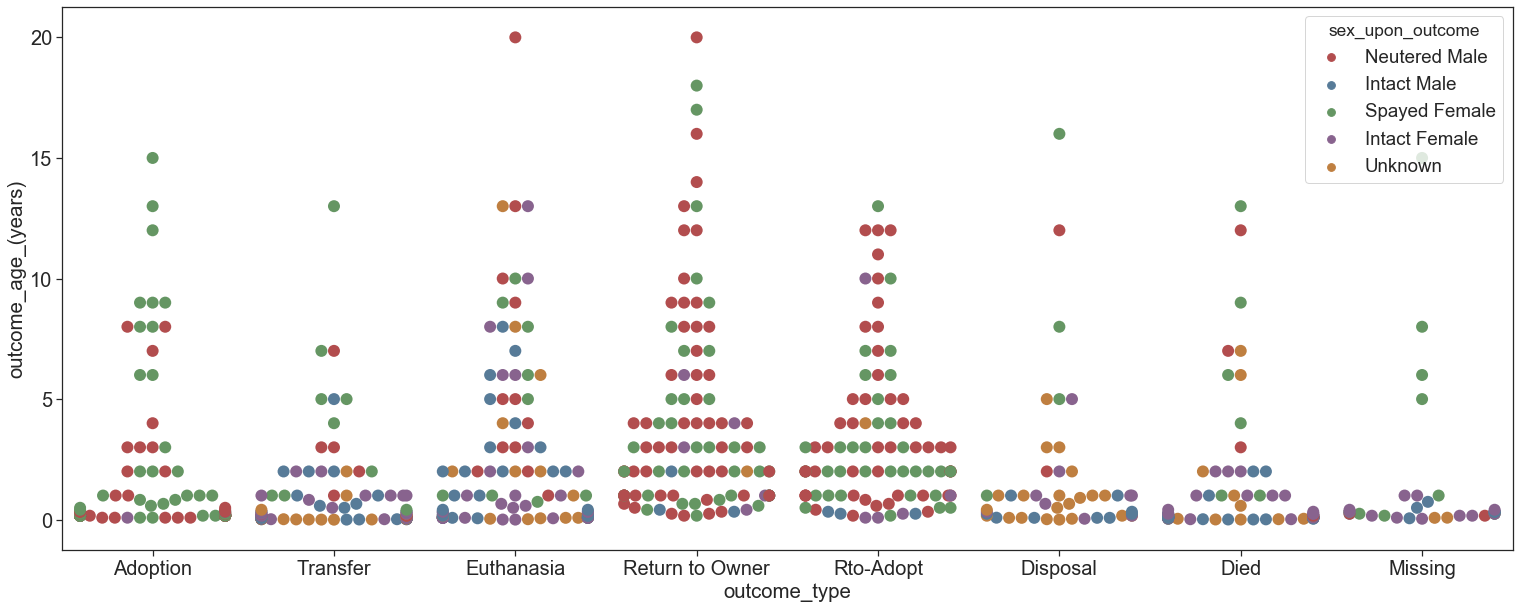

In [62]:
# Displays results of neuter/spay and gender by adoption result
cat_outcomes_sample = cats_df.sample(frac=1.0).groupby(['outcome_type']).head(100)
plt.figure(figsize=(26,10))
g = sns.swarmplot(x='outcome_type', y='outcome_age_(years)', hue='sex_upon_outcome', 
                  data=cat_outcomes_sample, size=12)
g.tick_params(labelsize=20)

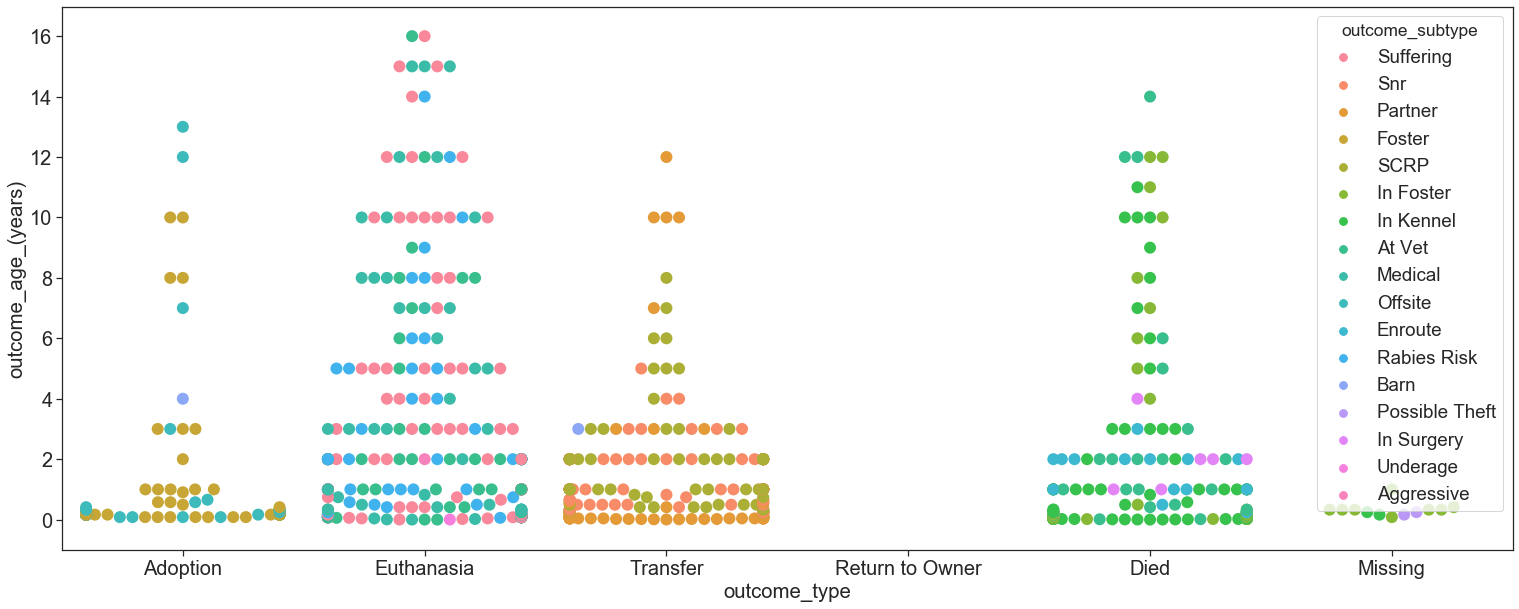

In [64]:
# Displays results based on outcome subtype and adoption results
cat_suboutcomes_sample = cats_df.sample(frac=1.0).groupby(['outcome_subtype']).head(100)
plt.figure(figsize=(26,10))
g = sns.swarmplot(x='outcome_type', y='outcome_age_(years)', hue='outcome_subtype', 
                  data=cat_suboutcomes_sample, size=12)
g.tick_params(labelsize=20)

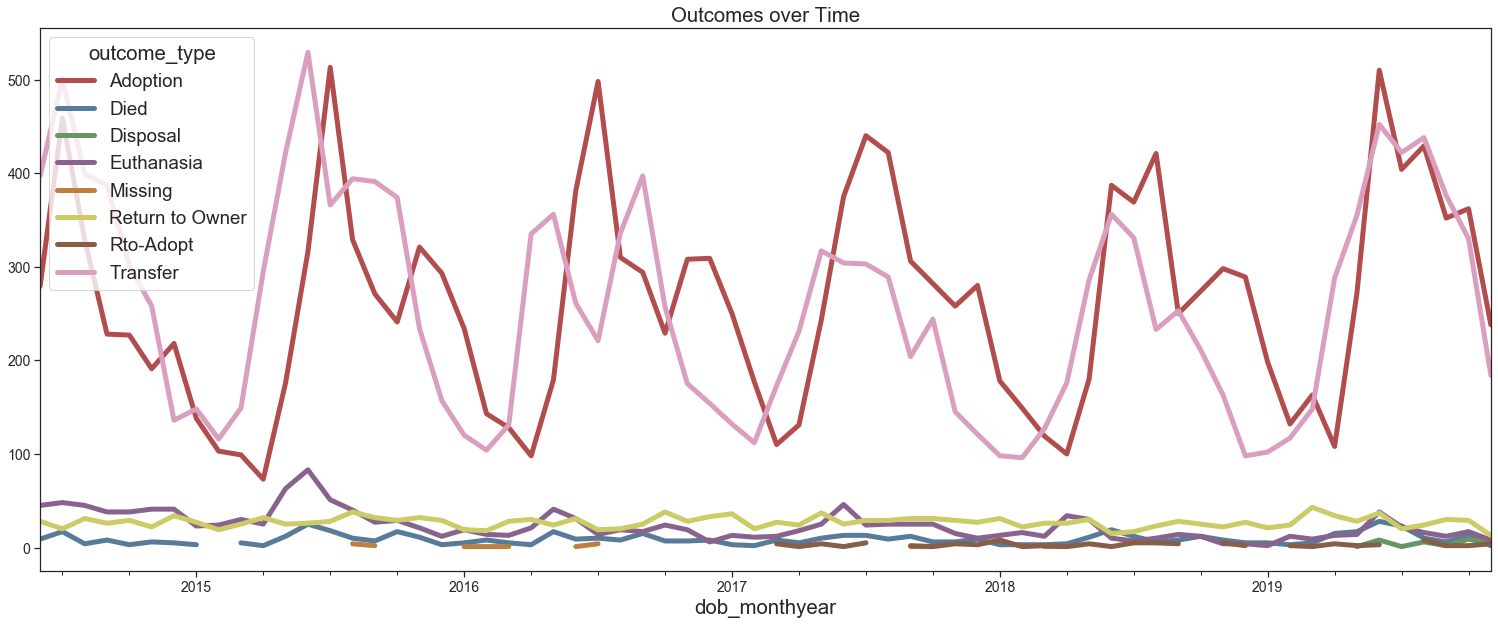

In [65]:
# Displays results based on adoption outcome and year
monthyear_outcomes = pd.pivot_table(cats_df, index=['dob_monthyear'], 
                                    columns=['outcome_type'], values='count', aggfunc=np.sum)
monthyear_outcomes.index = pd.to_datetime(monthyear_outcomes.index)
monthyear_outcomes.plot(fontsize=14, linewidth=5, title='Outcomes over Time', figsize=(26,10))

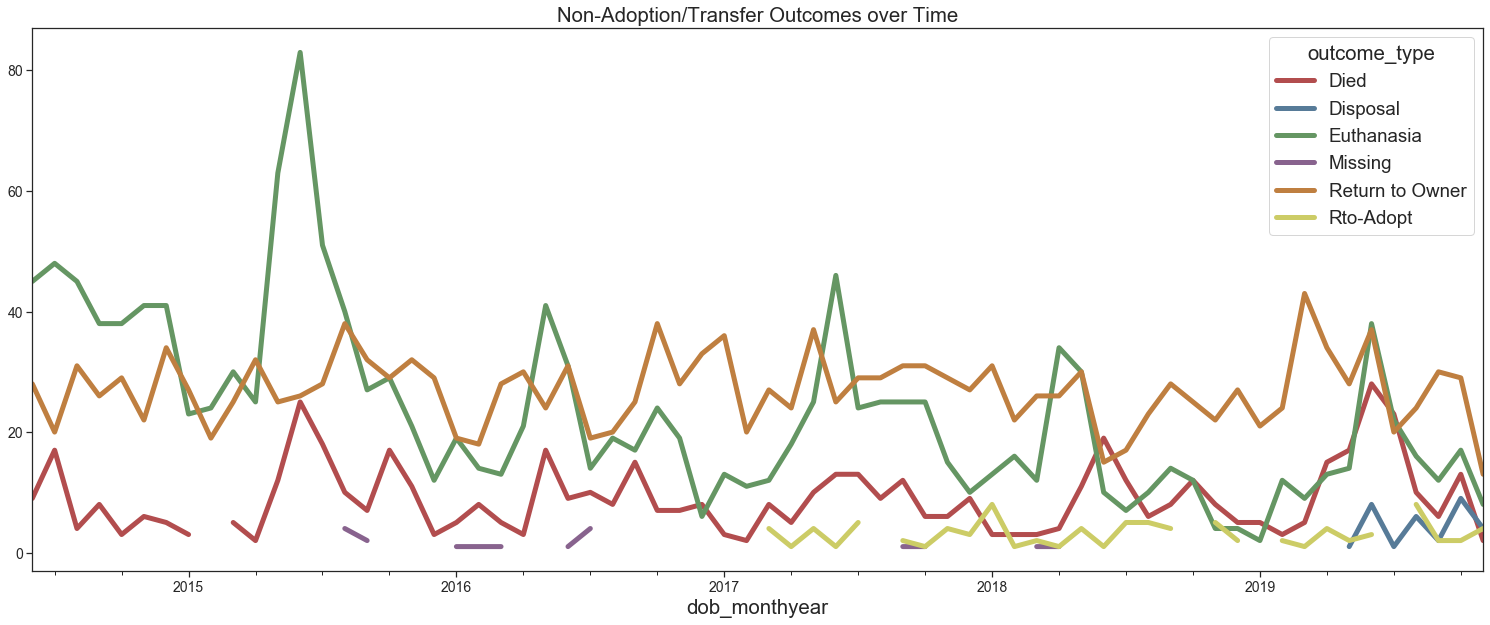

In [66]:
# Displays results based on non-adoption outcome and year
monthyear_outcomes2 = monthyear_outcomes.filter(items=['Died', 'Disposal', 'Euthanasia', 'Missing', 
                                                      'Return to Owner', 'Rto-Adopt'])
monthyear_outcomes2.plot(fontsize=14, linewidth=5, figsize=(26,10), 
                         title='Non-Adoption/Transfer Outcomes over Time')

ValueError: Invalid RGBA argument: masked

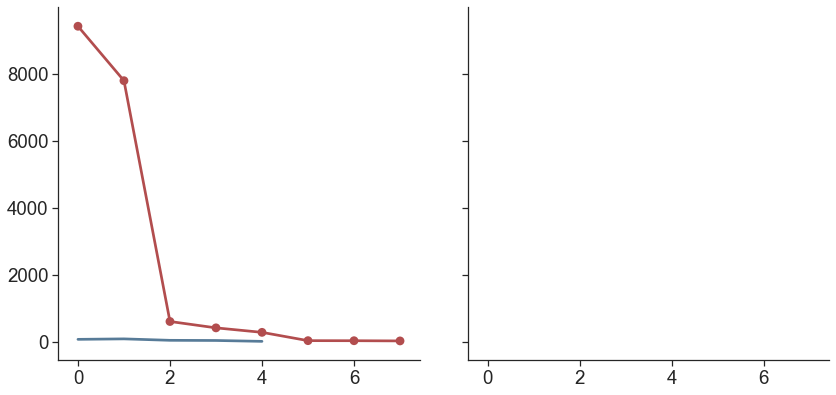

In [69]:
# Bug in this graph type 
# Displays results of adoption outcome by gender
agegroup_counts = cats_df.groupby(['age_group', 'sex'])['outcome_type'].value_counts().reset_index(name='count')
# g = sns.factorplot(x='outcome_type', y='count', hue='age_group', col='sex',
#                    data=agegroup_counts, size=6)
# g.set_xticklabels(rotation=90)

ValueError: Invalid RGBA argument: masked

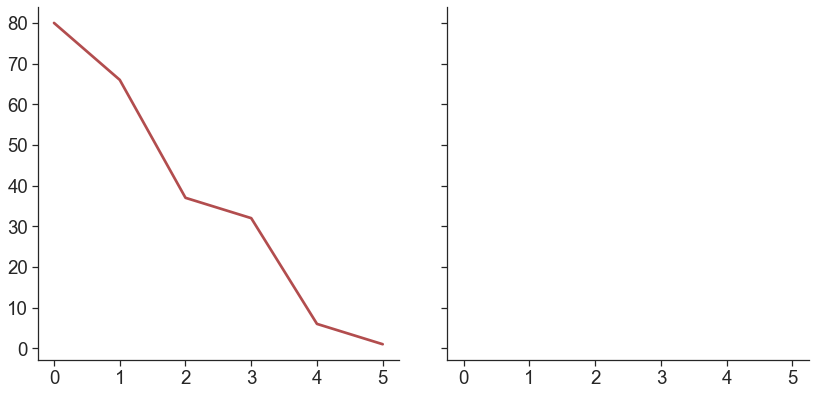

In [70]:
# Bug with graph type 
# Displays adoption outcome based on gender
agegroup_counts2 = agegroup_counts[agegroup_counts['age_group'] != agegroup_counts['age_group'].unique()[0]]
g = sns.factorplot(x='outcome_type', y='count', hue='age_group', col='sex', 
                   data=agegroup_counts2, size=6)
g.set_xticklabels(rotation=90)